In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from xgboost import XGBClassifier

# Set random seeds for reproducibility
np.random.seed(42)

## Exploratory Data Analysis (EDA) & Data Cleaning

In this section, we perform the initial exploration and cleaning of the audiobook dataset:

- **Dropped unnecessary columns** like `customer_id`, `book_length_sum`, `price_paid_sum`, `review_flag`, which were either redundant or not useful for modeling.
- **Replaced missing or zero values** in `review_score` with the global mean to maintain consistency.
- **Visualized distributions** of target and input features using histograms and value counts.
- **Plotted a correlation matrix** to identify multicollinearity and assess which features have strong relationships with the target `converted`.

This step helped us understand the structure, distribution, and relationships in our data, and prepared it for preprocessing and modeling.


In [12]:
# Load data
df = pd.read_csv('../datasets/audiobooks-data.csv')

# Assign column names
df.columns = [
    'customer_id',
    'book_length_sum',
    'book_length_avg',
    'price_paid_sum',
    'price_paid_avg',
    'review_flag',
    'review_score',
    'total_minutes_listened',
    'completion',
    'support_requests',
    'time_since_first_purchase',
    'converted'  # target
]

# check missing values
# print(df.isnull().sum())

# perform exploratory data analysis
# print(df.describe())

# drop customer id
df.drop(columns=['customer_id'], inplace=True)

# handle missing values for review_score, fill by mean
df['review_score'] = df['review_score'].fillna(df['review_score'].mean())
# replace 0 with mean
df['review_score'] = df['review_score'].replace(0, df['review_score'].mean())

# plot correlation matrix
# plt.figure(figsize=(10, 8))
# correlation_matrix = df.corr()
# plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
# plt.colorbar()
# plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
# plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
# plt.title('Correlation Matrix')
# plt.show()

# drop redundant, derivable, highly correlated features
df.drop(columns=['book_length_sum', 'price_paid_sum', 'review_flag', 'total_minutes_listened'], inplace=True)

# print the distribution of the target variable
# there is a class imbalance since we have more non-converted customers than converted ones
print(df['converted'].value_counts(normalize=True))



converted
0    0.841156
1    0.158844
Name: proportion, dtype: float64


## Preprocessing, Model Training, Evaluation, and Comparison

This section includes the full ML pipeline:

- **Preprocessing**:
  - Applied `log1p` transformation on skewed features (`price_paid_avg`, `completion`, `support_requests`).
  - Standardized continuous features using `StandardScaler`.
- **Train/Test Split** with stratification on the `converted` target to preserve class imbalance.
- **Trained and evaluated** multiple models:
  - Logistic Regression (with `class_weight='balanced'`)
  - Decision Tree
  - Random Forest
  - K-Nearest Neighbors
  - Neural Network (MLPClassifier)
  - XGBoost (boosted tree model)
- **Captured metrics**: Accuracy, Precision, Recall, F1 Score, ROC AUC, and Training Time.
- **Plotted ROC curves** for all models for visual comparison.

Each model was evaluated on its ability to identify likely repeat customers based on behavioral features, engagement, and time-based activity.


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training KNN...
Training NN (1 Layer ReLU)...
Training NN (2 Layers ReLU)...
Training NN (2 Layers Tanh)...
Training NN (3 Layers ReLU Adam)...
Training NN (Sigmoid Logistic)...


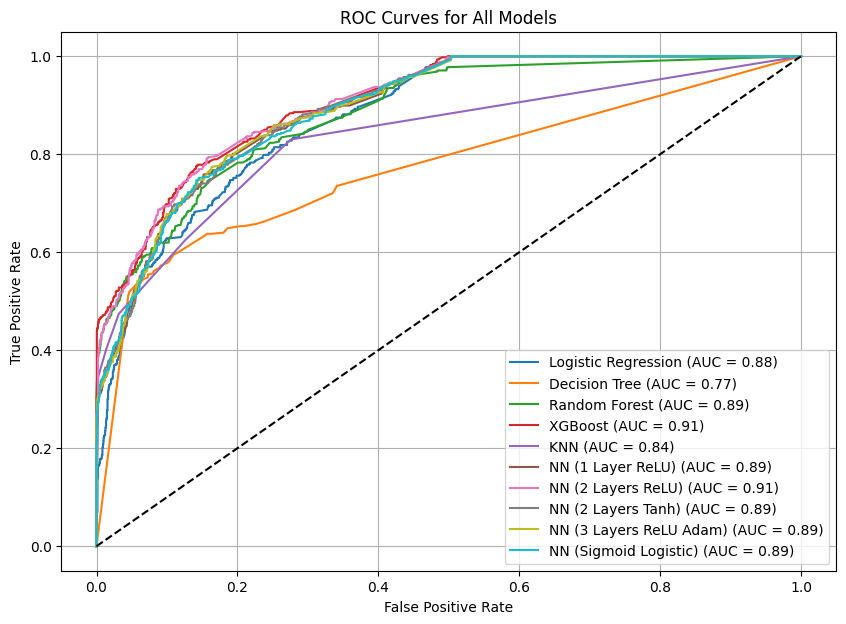

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
0,XGBoost,0.905928,0.869919,0.478747,0.617605,0.906546,0.098298
1,NN (2 Layers ReLU),0.903443,0.903226,0.438479,0.590361,0.905831,11.579455
2,NN (3 Layers ReLU Adam),0.886404,0.862857,0.337808,0.485531,0.894149,2.630769
3,NN (2 Layers Tanh),0.884629,0.765217,0.393736,0.519941,0.893602,4.557087
4,NN (1 Layer ReLU),0.883209,0.747899,0.398210,0.519708,0.893189,1.660857
5,NN (Sigmoid Logistic),0.881434,0.711610,0.425056,0.532213,0.892771,5.268246
6,Random Forest,0.893859,0.721557,0.539150,0.617157,0.885024,0.440488
7,Logistic Regression,0.780973,0.402299,0.782998,0.531511,0.877781,0.055114
8,KNN,0.889954,0.738676,0.474273,0.577657,0.835995,0.003944
9,Decision Tree,0.884629,0.678363,0.519016,0.588086,0.772217,0.017052


In [13]:
# Preprocess by log transforming and scaling features
def preprocess(df):
    df = df.copy()
    
    # Log transform skewed features
    df['price_paid_avg'] = np.log1p(df['price_paid_avg'])
    df['completion'] = np.log1p(df['completion'])
    df['support_requests'] = np.log1p(df['support_requests'])

    # Scale numerical features
    scaler = StandardScaler()
    features_to_scale = [
        'book_length_avg',
        'price_paid_avg',
        'time_since_first_purchase',
        'completion',
        'support_requests'
    ]
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    return df

# Split data into features and target, and then into training and testing sets
def split_data(df, target_col='converted'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train each model and evaluate its performance
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name='Model'):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Training Time (s)': end_time - start_time,
        'FPR': fpr,
        'TPR': tpr
    }
    return results

# Models to experiment with
models = [
    (LogisticRegression(class_weight='balanced', random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (XGBClassifier(eval_metric='logloss', n_estimators=50), "XGBoost"),
    (KNeighborsClassifier(), "KNN"),
    (MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=300, random_state=42), "NN (1 Layer ReLU)"),
    (MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=300, random_state=42), "NN (2 Layers ReLU)"),
    (MLPClassifier(hidden_layer_sizes=(64, 32), activation='tanh', max_iter=300, random_state=42), "NN (2 Layers Tanh)"),
    (MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=300, random_state=42), "NN (3 Layers ReLU Adam)"),
    (MLPClassifier(hidden_layer_sizes=(64, 64), activation='logistic', solver='adam', max_iter=300, random_state=42), "NN (Sigmoid Logistic)")
]

# Run experiments
df_preprocessed = preprocess(df)
X_train, X_test, y_train, y_test = split_data(df_preprocessed)

all_results = []
plt.figure(figsize=(10, 7))

for model, name in models:
    print(f"Training {name}...")
    result = train_and_evaluate(model, X_train, X_test, y_train, y_test, name)
    all_results.append(result)
    plt.plot(result['FPR'], result['TPR'], label=f"{name} (AUC = {result['ROC AUC']:.2f})")

# Plot ROC Curves
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame([{k: v for k, v in res.items() if k not in ['FPR', 'TPR']} for res in all_results])
results_df = results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
results_df


### Model Evaluation Summary

| Metric         | Best Model                     |
|----------------|--------------------------------|
| **Accuracy**   | XGBoost (0.91)                 |
| **Precision**  | XGBoost (0.87)                 |
| **Recall**     | Logistic Regression (0.78)     |
| **F1 Score**   | XGBoost (0.62), Random Forest (0.62) |
| **ROC AUC**    | XGBoost (0.91), NN (2 Layers ReLU) (0.91) |
| **Training Time** | KNN (0.004s), Decision Tree (0.017s) |

---

### Neural Network Insights

We experimented with 5 neural network configurations. Here’s what we can observe:

- **Best ROC AUC**: `NN (2 Layers ReLU)` matched XGBoost with **0.91** — deeper networks can capture more complex relationships.
- **Trade-off**: More layers like in `NN (3 Layers ReLU Adam)` increased training time but didn’t significantly improve performance — may indicate overfitting or diminishing returns.
- **Activation comparison**:
  - `ReLU` generally outperformed `Tanh` and `Sigmoid` due to faster training and less vanishing gradient.
  - `Tanh` and `Sigmoid` had stable but lower F1 and ROC AUC.
- **Training Efficiency**: `NN (1 Layer ReLU)` achieved strong performance with low training time — a solid lightweight baseline.

---

### Traditional Model Takeaways

| Model                 | Strengths                                   | Weaknesses                                   | When to Use                                      |
|----------------------|---------------------------------------------|----------------------------------------------|--------------------------------------------------|
| **XGBoost**           | Best overall metrics, handles imbalance well | Slightly higher training time                | Use when you want **maximum performance**        |
| **Random Forest**     | High F1 and recall, robust to overfitting    | Slower than simpler models                   | Use for a **strong, low-risk default baseline**  |
| **Logistic Regression** | Highest recall, fast training             | Very low precision (many false positives)    | Use when **recall is critical** (e.g. fraud detection) |
| **KNN**               | Fast training, simple logic                  | Low AUC, not scalable                        | Use for **simple, small datasets**               |
| **Decision Tree**     | Very fast, interpretable                    | Lower accuracy and ROC AUC                   | Use for **quick prototypes** or explainability   |

---

### Final Recommendations

- **Best overall**: `XGBoost` — high across all metrics.
- **Best neural net**: `NN (2 Layers ReLU)` — strong ROC AUC and decent F1.
- **Best simple model**: `Random Forest` — high-performing with low complexity.
- **Best high-recall**: `Logistic Regression` — useful when catching all positives is critical.
- **Best fast prototyping**: `KNN` and `Decision Tree` — lightweight and quick to implement.

---
